Read in data from the materials directories and conduct the analysis need for the paper 

In [1]:
# Standard 
import os, sys , copy ,shutil, logging, csv, json, logging
logger = logging.getLogger()
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
from streamm import values

# Import all the streamm modules
from streamm import *

%load_ext autoreload
%autoreload 2

In [2]:
from dask import delayed


In [3]:
local = resource.Resource('local')
local.load_json()
local.dir['home'] = '/Users/rlarsen/GITSTUFF/DApolymers'
peregrine = resource.Resource('peregrine')
peregrine.load_json()

Reading in resource json file res_local.json 
Reading in resource json file res_peregrine.json 


In [4]:
print local.dir['home']

/Users/rlarsen/GITSTUFF/DApolymers


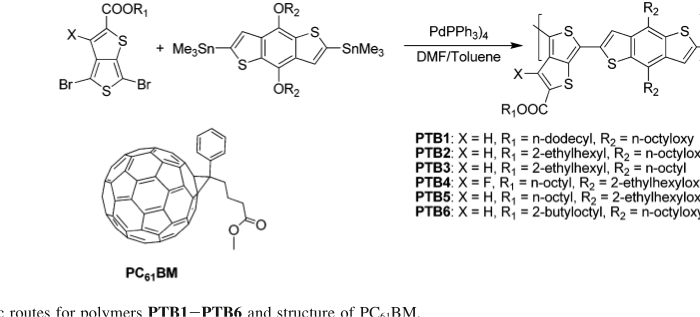

In [5]:
from IPython.display import Image
Image(filename=local.dir['home']+'/figures/PTBX.png')

In [6]:
def np_L(np_AIJ,D):
        
    size = np_AIJ[0].size 
    if( D[0].size != size ):
        print "Size error "
        return
    
    L = np.zeros((size,size),dtype=np.float64)
    
    for i in range(size):
        for j in range(size):
            L[i,j] = D[i,j] - np_AIJ[i,j] 

    return L

def np_sum_Vij(np_AIJ):
        
    size = np_AIJ[0].size 
    
    D = np.zeros((size,size),dtype=np.float64)
    
    for i in range(size):
        Dij = 0.0
        for j in range(size):
            Dij += np_AIJ[i,j]

        D[i,i] = Dij
                 
    return D

def np_Omega(Lplus):
        
    size = Lplus[0].size 
    
    Omega = np.zeros((size,size),dtype=np.float64)
    
    for i in range(size):
        for j in range(size):
            Omega[i,j] = Lplus[i,i]  + Lplus[j,j]  - Lplus[i,j]  - Lplus[j,i]  

    return Omega

def np_Alpha(Omega):

    size = Omega[0].size 
    
    Alpha = np.zeros((size,size),dtype=np.float64)
    
    for i in range(size):
        for j in range(size):
            if( i != j ):
                Alpha[i,j] = 1.0/Omega[i,j] 

    return Alpha    

def np_KT(Alpha):
    n_sqr = Alpha[0].size*Alpha[0].size 
    return  Alpha.sum()/n_sqr

In [7]:
def calc_KT(np_AIJ):
    '''
    Okay let's calculate the Kirchoff transport coefficient $K_{T}$ 

    For a network of n vertices

    The Laplacian matrix L is nxn

    $L = D - A$

    Where $A$ is the adjacency matrix and $D$ is the degree matrix 

    $ A_{ij} = |H_{ij}| $

    $ D_{ii} = \sum_{j} A_{ij} $ 


    Moore-Penrose Inverse $L^{+}$

    $\Omega_{ij} = L_{ii}^{+} + L_{jj}^{+} - L_{ij}^{+} -  L_{ji}^{+}$

    $\Alpha  = 1/\Omega_{ij} $

    $K_{T} = \frac{1}{n^2} \sum_{i,j} \Alpha_{ij}$    
    '''

    # Calculate $D_{ii}$ which is just the sum of each site with respect to all the other sites. 

    D = np_sum_Vij(np_AIJ)
    # $L = D - S$

    L = np_L(np_AIJ,D)    

    # Form the generalized Moore-Penrose inverse of the laplacian, ldagger
    Lplus = np.linalg.pinv(L)

    Omega = np_Omega(Lplus)

    Alpha = np_Alpha(Omega)
    
    KT = np_KT(Alpha)
    
    del D,L,Lplus,Omega,Alpha
    
    return KT

In [8]:
os.getcwd()

'/Users/rlarsen/GITSTUFF/DApolymers/notebooks'

In [9]:
proj_j_suf = "_unitKTv2"
proj_i = project.Project("DAPpolymers%s"%(proj_j_suf))
proj_i.load_json()

Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 


Create list of tags in correct order for outputing figures and tables 

In [10]:
name_l = []
name_l.append('BDT-TPD')
name_l.append('PTB1')
name_l.append('PTB5')
name_l.append('PTB4')
name_l.append('PTB7')
name_l.append('PCE10')

In [11]:
tag_l = []
for name_i in name_l:
    calc_i = None 
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print calc_i.tag
    tag_l.append(calc_i.tag)
    

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2


Read in data files from materails directory

In [15]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    calc_i.dir['materials'] = local.dir['home']+'/materials/'+calc_i.properties['name']
    print calc_i.dir['materials']    

/Users/rlarsen/GITSTUFF/DApolymers/materials/BDT-TPD
/Users/rlarsen/GITSTUFF/DApolymers/materials/PTB1
/Users/rlarsen/GITSTUFF/DApolymers/materials/PTB5
/Users/rlarsen/GITSTUFF/DApolymers/materials/PTB4
/Users/rlarsen/GITSTUFF/DApolymers/materials/PTB7
/Users/rlarsen/GITSTUFF/DApolymers/materials/PCE10


In [16]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    print calc_i.properties['name'],calc_i.dir['materials']
    os.chdir(calc_i.dir['materials'])     
    calc_i.dih_ij = pd.read_csv(calc_i.files['output']['dih_CCCC'])
    calc_i.unit_ij = pd.read_csv(calc_i.files['output']['unit_ij'])
    calc_i.mol_ij = pd.read_csv(calc_i.files['output']['mol_ij'])        

BDT-TPD /Users/rlarsen/GITSTUFF/DApolymers/materials/BDT-TPD
PTB1 /Users/rlarsen/GITSTUFF/DApolymers/materials/PTB1
PTB5 /Users/rlarsen/GITSTUFF/DApolymers/materials/PTB5
PTB4 /Users/rlarsen/GITSTUFF/DApolymers/materials/PTB4
PTB7 /Users/rlarsen/GITSTUFF/DApolymers/materials/PTB7
PCE10 /Users/rlarsen/GITSTUFF/DApolymers/materials/PCE10


Calculate Jo 

In [17]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    print 'proj_i.calculations[\''+tag_i+'\'].properties[\'Jocos\'] = '

proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['Jocos'] = 
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['Jocos'] = 
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['Jocos'] = 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['Jocos'] = 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['Jocos'] = 
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2'].properties['Jocos'] = 


In [20]:
proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['Jocos'] = 0.101
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['Jocos'] = 0.154
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['Jocos'] = 0.154
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['Jocos'] = 0.222
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['Jocos'] = 0.222
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2'].properties['Jocos'] = 0.194

In [19]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    print 'proj_i.calculations[\''+tag_i+'\'].properties[\'theta_n1\'] = '

proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n1'] = 
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n1'] = 
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n1'] = 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['theta_n1'] = 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['theta_n1'] = 
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2'].properties['theta_n1'] = 


In [21]:
proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n2'] = -9.0
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n2'] =  -165.6
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n2'] = -165.6
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['theta_n2'] = -20.3
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['theta_n2'] = -20.3
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2'].properties['theta_n2'] = -163.2

In [22]:
proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n1'] = -177.7
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n1'] = 155.9
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2'].properties['theta_n1'] = 155.9
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['theta_n1'] = 27.2
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2'].properties['theta_n1'] = 27.2
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2'].properties['theta_n1'] = 153.1

In [23]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    t_rad = np.deg2rad(float(calc_i.properties['theta_n2']))
    cos_i = abs(np.cos(t_rad))
    calc_i.properties['Jo'] = round(calc_i.properties['Jocos']/cos_i,2)
    
    print calc_i.properties['Jocos'],calc_i.properties['theta_n2'],cos_i,calc_i.properties['Jo']

0.101 -9.0 0.987688340595 0.1
0.154 -165.6 0.968583161129 0.16
0.154 -165.6 0.968583161129 0.16
0.222 -20.3 0.937888934612 0.24
0.222 -20.3 0.937888934612 0.24
0.194 -163.2 0.957319497532 0.2


In [24]:
calc_i = proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2']
calc_i.properties['Jo'] = 0.24

In [25]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    print calc_i.properties['Jocos'],calc_i.properties['theta_n2'],cos_i,calc_i.properties['Jo']

0.101 -9.0 0.957319497532 0.1
0.154 -165.6 0.957319497532 0.16
0.154 -165.6 0.957319497532 0.16
0.222 -20.3 0.957319497532 0.24
0.222 -20.3 0.957319497532 0.24
0.194 -163.2 0.957319497532 0.24


In [27]:
os.chdir('%s/tables/'%(local.dir['home']))

t_name = 'Jo_v1.tex'

table_lines = '\\begin{tabular}{|c|c|} \n'
table_lines += '\\hline \n'
table_lines += 'Polymer & $J_{o}$ (eV)  \\\\ \\hline \n'

for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.2f '%(calc_i.properties['Jo'])
    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
f = open(t_name,'w')
f.write(table_lines)
f.close()

\begin{tabular}{|c|c|} 
\hline 
Polymer & $J_{o}$ (eV)  \\ \hline 
BDT-TPD  &     0.10  \\ 
PTB1  &     0.16  \\ 
PTB5  &     0.16  \\ 
PTB4  &     0.24  \\ 
PTB7  &     0.24  \\ 
PCE10  &     0.24  \\ 
\hline 
\end{tabular}


In [28]:
# Set Jo to a constand
setJotoConst = False 
if( setJotoConst ):
    for tag_i in tag_l:
        calc_i = proj_i.calculations[tag_i]
        calc_i.properties['Jo'] = 0.16

Calculate all Jo cos(theta) values

In [29]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    Jo = calc_i.properties['Jo']
    print calc_i.properties['name'], Jo
    calc_i.dih_ij['Jocos'] = calc_i.dih_ij['cosine'].apply(lambda x: abs(x)*Jo)


    

BDT-TPD 0.1
PTB1 0.16
PTB5 0.16
PTB4 0.24
PTB7 0.24
PCE10 0.24


BDT-TPD
BDT-TPD 0.0889078343509
PTB1
PTB1 0.141010781614
PTB5
PTB5 0.133602647527
PTB4
PTB4 0.192339902593
PTB7
PTB7 0.200326403378
PCE10
PCE10 0.18826822518


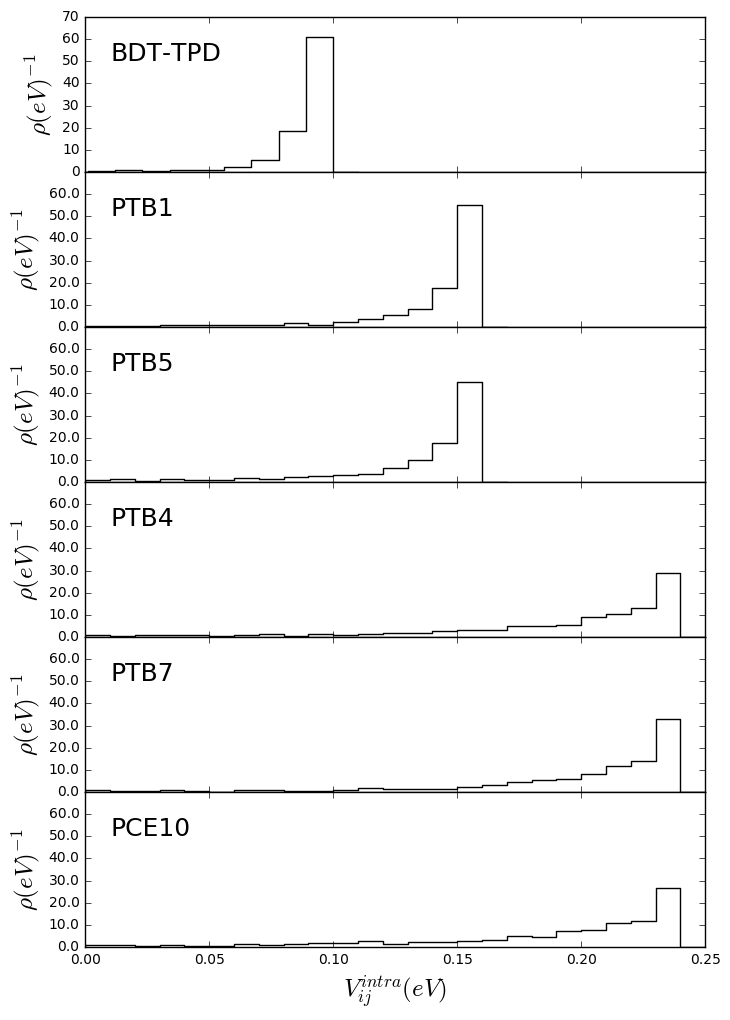

In [30]:
os.chdir('%s/figures/'%(local.dir['home']))
ms = 3
led_x = 0.015
led_y = 0.001
fontsz_leg = 16
fontsz_text = 18

fig, ax = plt.subplots(6,sharex=True)

i = 0 
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    print calc_i.properties['name']
    Polymer = calc_i.properties['name']
    mean = calc_i.dih_ij['Jocos'].mean()
    # 
    print Polymer,mean
    # mol_SIJ['SIJ_max'].hist(ax=ax[i], bins=50, bottom=0.1)
    # ax.set_yscale('log')    


    val_i = values.Values('Jocos',calc_i.dih_ij['Jocos'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))
    val_i.calc_stats()
    val_i.set_bins(.01)
    val_i.calc_hist()
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'k-',ls = "steps",label=r'$J_{o}cos(\theta_{ij})$')

    ax[i].set_xlim(0,0.25)
    ax[i].set_ylim(0.0,70.0)
    #ax[i].text(55,0.015,name_i)
    #ax[i].set_xlim(0,1.0)
    #ax[i].set_ylim(0.0,6.0)
    ax[i].text(0.01,50.0,Polymer,fontsize=fontsz_text)

    if( i > 0 ):
        labels=ax[i].get_yticks().tolist()
        labels[-1]=''
        ax[i].set_yticklabels(labels)    


    ax[i].set_ylabel(r'$\rho (eV)^{-1}$',fontsize=fontsz_text)
    i += 1

#ax[0].legend(loc=(0.6,0.250),prop={'size':fontsz_leg})


fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)
ax[i-1].set_xlabel(r'$V_{ij}^{intra} (eV)$',fontsize=fontsz_text)


fig.savefig('Jocos_v1.pdf',format='pdf')

In [31]:
os.chdir('%s/tables/'%(local.dir['home']))
t_name = 'Vintra_v1.tex'

table_lines = '\\begin{tabular}{|c|c|c|c|} \n'
table_lines += '\\hline \n'
table_lines += 'Polymer & $<V_{ij}^{intra}>$ ($\sigma$) (eV) \\\\ \\hline \n'

for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.3f (%8.3f) '%(calc_i.dih_ij['Jocos'].mean(),calc_i.dih_ij['Jocos'].std())
    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
#f = open(t_name,'w')
#f.write(table_lines)
#f.close()

\begin{tabular}{|c|c|c|c|} 
\hline 
Polymer & $<V_{ij}^{intra}>$ ($\sigma$) (eV) \\ \hline 
BDT-TPD  &    0.089 (   0.015)  \\ 
PTB1  &    0.141 (   0.028)  \\ 
PTB5  &    0.134 (   0.035)  \\ 
PTB4  &    0.192 (   0.054)  \\ 
PTB7  &    0.200 (   0.049)  \\ 
PCE10  &    0.188 (   0.056)  \\ 
\hline 
\end{tabular}


Calculate the K_{T} for each oligomer based upon V_ij^intra

In [32]:
def np_dih_moldf(dih_ij):
    
    mol_o = dih_ij['mol_i'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()
    mol_n = dih_ij['mol_i'].max() 
    
    mol_As = {}
    for mol_i in range(mol_o,mol_n+1):
        dih_mol_i = dih_ij[ ( dih_ij['mol_i'] == mol_i ) ]

        g_o = dih_mol_i['g_i'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()
        g_n = dih_mol_i['g_j'].max() 

        size = g_n - g_o + 1

        np_AIJ = np.zeros((size,size),dtype=np.float64)
        for g_i in range(g_o,g_n+1):
            i = g_i - g_o
            dih_i = dih_mol_i[ ( dih_mol_i['g_i'] == g_i ) ]
            g_j_l = dih_i['g_j'].values
            for g_j in g_j_l:
                j = g_j - g_o
                Jocos =  dih_ij[ (dih_ij['g_i'] == g_i ) & (dih_ij['g_j'] == g_j ) ]['Jocos'].values
                if( len(Jocos) > 1 ):
                    print 'table error %d %d returned list '%(g_i,g_j)
                    print cos_ij 
                np_AIJ[i,j] =  Jocos[0]
                np_AIJ[j,i] =  Jocos[0]
                
        mol_As[mol_i] = np_AIJ
 
    return mol_As   

In [33]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    print tag_i
    dih_ij = calc_i.dih_ij
    calc_i.Vijintra_Jocos = np_dih_moldf(dih_ij)

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2


In [34]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    dih_ij = calc_i.dih_ij
    
    mol_o = dih_ij['mol_i'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()
    mol_n = dih_ij['mol_i'].max() 
    
    print mol_o,mol_n
    
    mol_KT = {}
    mol_KT['mol_i']  = []
    mol_KT['Jocos']  = []


    for mol_i in range(mol_o,mol_n+1):

        mol_KT['mol_i'].append(mol_i)
        mol_KT['Jocos'].append(calc_KT(calc_i.Vijintra_Jocos[mol_i]))
        
    calc_i.mol_KT = pd.DataFrame(mol_KT)
    

1 197
0 172
0 192
0 192
0 192
0 172


In [35]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    print calc_i.mol_KT['Jocos'].mean(),calc_i.mol_KT['Jocos'].std()

0.033619657992 0.00288225327702
0.0530172050007 0.00512452617321
0.0494287914732 0.00669108709671
0.070971685549 0.00982710180848
0.0742563181319 0.0091843887953
0.0690597980101 0.0104040922825


In [36]:
os.chdir('%s/tables/'%(local.dir['home']))
t_name = 'VintraKT_v1.tex'

table_lines = '\\begin{tabular}{|c|c|c|c|c|} \n'
table_lines += '\\hline \n'
table_lines += 'Polymer & $J_{o}$ (meV)  & $<V_{ij}^{intra}>$ ($\sigma$) (meV) & $K_{T}(V_{ij}^{intra})$  ($\sigma$) (meV)   \\\\ \\hline \n'
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.1f '%(calc_i.properties['Jo']*1000)

    
    table_lines += '& %8.3f (%8.3f) '%(calc_i.dih_ij['Jocos'].mean()*1000,calc_i.dih_ij['Jocos'].std()*1000)
    table_lines += '& %8.3f (%8.3e) '%(calc_i.mol_KT['Jocos'].mean()*1000,calc_i.mol_KT['Jocos'].std()*1000)

    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
#f = open(t_name,'w')
#f.write(table_lines)
#f.close()

\begin{tabular}{|c|c|c|c|c|} 
\hline 
Polymer & $J_{o}$ (meV)  & $<V_{ij}^{intra}>$ ($\sigma$) (meV) & $K_{T}(V_{ij}^{intra})$  ($\sigma$) (meV)   \\ \hline 
BDT-TPD  &    100.0 &   88.908 (  14.997) &   33.620 (2.882e+00)  \\ 
PTB1  &    160.0 &  141.011 (  28.305) &   53.017 (5.125e+00)  \\ 
PTB5  &    160.0 &  133.603 (  34.982) &   49.429 (6.691e+00)  \\ 
PTB4  &    240.0 &  192.340 (  54.008) &   70.972 (9.827e+00)  \\ 
PTB7  &    240.0 &  200.326 (  48.606) &   74.256 (9.184e+00)  \\ 
PCE10  &    240.0 &  188.268 (  56.202) &   69.060 (1.040e+01)  \\ 
\hline 
\end{tabular}


Build entire wieghted adjacency matrix $A$

In [37]:
def np_dihdf(dih_ij,key):
    
    g_o = dih_ij['g_i'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()
    g_n = dih_ij['g_j'].max() 
    
    size = g_n - g_o + 1
    
    print g_o,g_n,size

    np_AIJ = np.zeros((size,size),dtype=np.float64)
    for g_i in range(g_o,g_n+1):
        dih_i = dih_ij[ ( dih_ij['g_i'] == g_i ) ]
        g_j_l = dih_i['g_j'].values
        
        for g_j in g_j_l:
            Jocos =  dih_i[ (dih_i['g_j'] == g_j ) ][key].values
            if( len(Jocos) > 1 ):
                print 'table error %d %d returned list '%(g_i,g_j)
                print Jocos 
            np_AIJ[g_i,g_j] =  Jocos[0]
            np_AIJ[g_j,g_i] =  Jocos[0]


    return np_AIJ   

In [38]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    dih_ij = calc_i.dih_ij
    calc_i.np_Jocos = np_dihdf(dih_ij,'Jocos')

0 1969 1970
0 1729 1730
0 1929 1930
0 1929 1930
0 1929 1930
0 1729 1730


In [39]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    calc_i.properties['KT_Jocos'] = calc_KT(calc_i.np_Jocos)
    print calc_i.properties['KT_Jocos']

0.0273976590581
0.0426478698576
0.0368687499434
0.0523779310763
0.0553674131436
0.050148541964


In [41]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    os.chdir(calc_i.dir['materials'])     
    np.save('Jocos.npy', calc_i.np_Jocos) 

Fix BDT-TPD with mol 1 -N instead of 0- (N-1)

In [42]:
    calc_i = proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2']

    calc_i.unit_ij['mol_i'] =  calc_i.unit_ij['mol_i'].apply(lambda x: x - calc_i.unit_ij['mol_i'].min() )
    calc_i.unit_ij['mol_j'] =  calc_i.unit_ij['mol_j'].apply(lambda x: x - calc_i.unit_ij['mol_j'].min() )    

Calculate Vij using Sij and E_I and E_J

In [44]:
def calc_VijIJ(row_i):
    gamma = 1.168
    e_bar = -0.5*(row_i['HOMO_I'] + row_i['HOMO_J'])
    return gamma*abs(row_i['Sij'])*e_bar

In [45]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    mol_IJ = calc_i.mol_ij.rename(columns={'HOMO_i':'HOMO_I','HOMO_j':'HOMO_J'})

    homo_IJ = mol_IJ[['mol_i','mol_j','HOMO_I','HOMO_J']]
    
    calc_i.unit_ij['absSij'] = calc_i.unit_ij['Sij'].abs()


    unit_ij_s = calc_i.unit_ij[ calc_i.unit_ij['absSij'] > 1.e-6  ]
    calc_i.unit_ij_IJ = pd.merge(unit_ij_s,homo_IJ,on=['mol_i','mol_j'])

    #print unit_ij_IJ.columns

    calc_i.unit_ij_IJ['Vij_IJ'] = calc_i.unit_ij_IJ.apply(calc_VijIJ,axis=1)
    
    del mol_IJ,homo_IJ

In [46]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    print calc_i.properties['name'],calc_i.unit_ij_IJ['Vij'].max(),calc_i.unit_ij_IJ['Vij_IJ'].max(),calc_i.unit_ij_IJ['Sij'].max()

BDT-TPD 0.212667979344 0.191014373013 0.0238
PTB1 0.267518772461 0.21215981567 0.0293
PTB5 0.334136806922 0.265056560206 0.0369
PTB4 0.246568640336 0.18773009971 0.0244
PTB7 0.263856091448 0.212719446442 0.0283
PCE10 0.279632765894 0.235033575133 0.0284


In [47]:
#os.chdir('/Users/tkemper/Projects/DApolymers/tables/')
os.chdir('%s/tables/'%(local.dir['home']))
t_name = 'Vij_IJ_v1.tex'

table_lines = '\\begin{tabular}{|c|c|c|c|c|} \n'
table_lines += '\\hline \n'
table_lines += 'Polymer  & $J_{o}$ (meV)  & $<V_{ij}^{intra}>$ ($\sigma$) (meV)  & $<V_{ij}^{inter}>$ ($\sigma$) (meV)  \\\\ \\hline \n'

for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.1f '%(calc_i.properties['Jo']*1000)
    table_lines += '& %8.1f (%8.1f) '%(calc_i.dih_ij['Jocos'].mean()*1000,calc_i.dih_ij['Jocos'].std()*1000)    
    table_lines += '& %8.1f (%8.1f) '%(calc_i.unit_ij_IJ['Vij_IJ'].mean()*1000,calc_i.unit_ij_IJ['Vij_IJ'].std()*1000)

    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
f = open(t_name,'w')
f.write(table_lines)
f.close()

\begin{tabular}{|c|c|c|c|c|} 
\hline 
Polymer  & $J_{o}$ (meV)  & $<V_{ij}^{intra}>$ ($\sigma$) (meV)  & $<V_{ij}^{inter}>$ ($\sigma$) (meV)  \\ \hline 
BDT-TPD  &    100.0 &     88.9 (    15.0) &     11.4 (    20.5)  \\ 
PTB1  &    160.0 &    141.0 (    28.3) &     11.4 (    23.1)  \\ 
PTB5  &    160.0 &    133.6 (    35.0) &     11.3 (    23.8)  \\ 
PTB4  &    240.0 &    192.3 (    54.0) &     10.6 (    22.3)  \\ 
PTB7  &    240.0 &    200.3 (    48.6) &     10.9 (    22.9)  \\ 
PCE10  &    240.0 &    188.3 (    56.2) &      7.9 (    17.8)  \\ 
\hline 
\end{tabular}


Find V_IJ_max 

In [48]:
def find_gMax(Sij_df):
    #
    gSV_max = {}
    gSV_max['g_i'] = []
    gSV_max['S_max'] = []
    gSV_max['V_max'] = []

    #
    for g_i in  Sij_df['g_i'].unique():
        Sij_max = Sij_df[ Sij_df['g_i'] == g_i ]['absSij'].max()
        Vij_max = Sij_df[ Sij_df['g_i'] == g_i ]['Vij_IJ'].max()
        #
        gSV_max['g_i'].append(g_i)
        gSV_max['S_max'].append(Sij_max)
        gSV_max['V_max'].append(Vij_max)
    #
    return pd.DataFrame(gSV_max)

In [49]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    
    res_D = [x for x in calc_i.unit_ij_IJ['resname_i'].values if( x[0] == 'D') ][0]

    res_A = [x for x in calc_i.unit_ij_IJ['resname_i'].values if( x[0] == 'A') ][0]

    print res_D,res_A

    et_ij3 = calc_i.unit_ij_IJ

    calc_i.et_DA = et_ij3[ (et_ij3['resname_i'] == res_D) & (et_ij3['resname_j'] == res_A) ]
    calc_i.et_DD = et_ij3[ (et_ij3['resname_i'] == res_D) & (et_ij3['resname_j'] == res_D) ]
    calc_i.et_AA = et_ij3[ (et_ij3['resname_i'] == res_A) & (et_ij3['resname_j'] == res_A) ]        
    

D1 A31
D1 A2
D1 A31
D1 A23
D1 A23
D1 A23


In [50]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    #if( calc_i.meta['status'] == 'processed' ):
    print calc_i.tag
    name_i = str(calc_i.properties['name'])  
    print name_i
    calc_i.DAgSV_max = find_gMax(calc_i.et_DA)
    calc_i.DDgSV_max = find_gMax(calc_i.et_DD)
    calc_i.AAgSV_max = find_gMax(calc_i.et_AA)        

D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2
PTB1
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2
BDT-TPD
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2
PTB5
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
PTB7
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
PTB4
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2
PCE10


In [51]:
#os.chdir('/Users/tkemper/Projects/DApolymers/tables/')
os.chdir('%s/tables/'%(local.dir['home']))
t_name = 'Sij_max_v1.tex'

table_lines = '\\begin{tabular}{|c|c|c|c|c|c|c|} \n'
table_lines += '\\hline \n'
table_lines = 'Polymer & $S_{i}^{max}(DD)$ ($\sigma$) (eV) &   $S_{i}^{max}(AA)$($\sigma$) (eV) &   $S_{i}^{max}(DA)$($\sigma$) (eV) \\\\ \hline \n'


for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.4f & %8.2e '%(calc_i.DDgSV_max['S_max'].mean(),calc_i.DDgSV_max['S_max'].std())
    table_lines += '& %8.4f & %8.2e '%(calc_i.AAgSV_max['S_max'].mean(),calc_i.AAgSV_max['S_max'].std())
    table_lines += '& %8.4f & %8.2e '%(calc_i.DAgSV_max['S_max'].mean(),calc_i.DAgSV_max['S_max'].std())



    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
f = open(t_name,'w')
f.write(table_lines)
f.close()


Polymer & $S_{i}^{max}(DD)$ ($\sigma$) (eV) &   $S_{i}^{max}(AA)$($\sigma$) (eV) &   $S_{i}^{max}(DA)$($\sigma$) (eV) \\ \hline 
BDT-TPD  &   0.0047 & 4.19e-03 &   0.0017 & 2.04e-03 &   0.0030 & 3.12e-03  \\ 
PTB1  &   0.0036 & 3.55e-03 &   0.0038 & 5.05e-03 &   0.0039 & 4.48e-03  \\ 
PTB5  &   0.0041 & 4.07e-03 &   0.0041 & 5.87e-03 &   0.0038 & 4.41e-03  \\ 
PTB4  &   0.0039 & 3.79e-03 &   0.0031 & 4.50e-03 &   0.0037 & 4.36e-03  \\ 
PTB7  &   0.0035 & 3.93e-03 &   0.0036 & 4.96e-03 &   0.0036 & 4.14e-03  \\ 
PCE10  &   0.0021 & 2.50e-03 &   0.0023 & 3.83e-03 &   0.0024 & 3.47e-03  \\ 
\hline 
\end{tabular}


Find V_IJ max 

In [52]:
print calc_i.mol_ij.columns

Index([u'Unnamed: 0', u'SIJ_AA_N', u'SIJ_DA_N', u'SIJ_DD_N', u'SIJ_N',
       u'mol_i', u'mol_j', u'tag_x', u'g_i', u'total_i', u'HOMO_i', u'LUMO_i',
       u'tag_y', u'g_j', u'total_j', u'HOMO_j', u'LUMO_j', u'VIJ', u'VIJ_DA',
       u'VIJ_DD', u'VIJ_AA'],
      dtype='object')


In [53]:
def find_molMax(mol_ij):
    #
    gSV_max = {}
    gSV_max['mol_i'] = []
    gSV_max['SIJ_max'] = []
    gSV_max['VIJ_max'] = []

    #
    for mol_i in  mol_ij['mol_i'].unique():
        SIJ_max = mol_ij[ mol_ij['mol_i'] == mol_i ]['SIJ_N'].max()
        VIJ_max = mol_ij[ mol_ij['mol_i'] == mol_i ]['VIJ'].max()
        #
        gSV_max['mol_i'].append(mol_i)
        gSV_max['SIJ_max'].append(SIJ_max)
        gSV_max['VIJ_max'].append(VIJ_max)
    #
    return pd.DataFrame(gSV_max)

In [54]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    #if( calc_i.meta['status'] == 'processed' ):
    print calc_i.tag
    name_i = str(calc_i.properties['name'])  
    print name_i
    calc_i.molSV_max = find_molMax(calc_i.mol_ij)    

D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_unitKTv2
PTB1
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_unitKTv2
BDT-TPD
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_unitKTv2
PTB5
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
PTB7
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_unitKTv2
PTB4
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_unitKTv2
PCE10


In [55]:
#os.chdir('/Users/tkemper/Projects/DApolymers/tables/')
os.chdir('%s/tables/'%(local.dir['home']))
t_name = 'Vij_max_v1.tex'


table_lines = '\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|} \n'
table_lines += '\\hline \n'
table_lines += 'Polymer & $<V_{ij}^{intra}>$ ($\sigma$) (eV)  & $<V_{ij}^{inter}>$ ($\sigma$) (eV)  & $V_{i}^{max}(DD)$ ($\sigma$)  &   $V_{i}^{max}(AA)$($\sigma$) &   $V_{i}^{max}(DA)$($\sigma$)  & $V_{I}^{max}$ ($\sigma$)  \\\\ \hline \n'

for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.3f (%8.3e) '%(calc_i.dih_ij['Jocos'].mean(),calc_i.dih_ij['Jocos'].std())    
    table_lines += '& %8.3f (%8.3e) '%(calc_i.unit_ij_IJ['Vij_IJ'].mean(),calc_i.unit_ij_IJ['Vij_IJ'].std())
    table_lines += '& %8.4f (%8.2e) '%(calc_i.DDgSV_max['V_max'].mean(),calc_i.DDgSV_max['V_max'].std())
    table_lines += '& %8.4f (%8.2e) '%(calc_i.AAgSV_max['V_max'].mean(),calc_i.AAgSV_max['V_max'].std())
    table_lines += '& %8.4f (%8.2e) '%(calc_i.DAgSV_max['V_max'].mean(),calc_i.DAgSV_max['V_max'].std())
    table_lines += '& %8.4f (%8.2e) '%(calc_i.molSV_max['VIJ_max'].mean(),calc_i.molSV_max['VIJ_max'].std())




    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
f = open(t_name,'w')
f.write(table_lines)
f.close()



\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|} 
\hline 
Polymer & $<V_{ij}^{intra}>$ ($\sigma$) (eV)  & $<V_{ij}^{inter}>$ ($\sigma$) (eV)  & $V_{i}^{max}(DD)$ ($\sigma$)  &   $V_{i}^{max}(AA)$($\sigma$) &   $V_{i}^{max}(DA)$($\sigma$)  & $V_{I}^{max}$ ($\sigma$)  \\ \hline 
BDT-TPD  &    0.089 (1.500e-02) &    0.011 (2.047e-02) &   0.0372 (3.35e-02) &   0.0137 (1.63e-02) &   0.0243 (2.50e-02) &   0.0278 (1.26e-02)  \\ 
PTB1  &    0.141 (2.830e-02) &    0.011 (2.306e-02) &   0.0258 (2.58e-02) &   0.0278 (3.67e-02) &   0.0285 (3.26e-02) &   0.0281 (1.22e-02)  \\ 
PTB5  &    0.134 (3.498e-02) &    0.011 (2.381e-02) &   0.0292 (2.92e-02) &   0.0295 (4.20e-02) &   0.0274 (3.16e-02) &   0.0283 (1.33e-02)  \\ 
PTB4  &    0.192 (5.401e-02) &    0.011 (2.231e-02) &   0.0287 (2.81e-02) &   0.0233 (3.34e-02) &   0.0278 (3.24e-02) &   0.0282 (1.35e-02)  \\ 
PTB7  &    0.200 (4.861e-02) &    0.011 (2.294e-02) &   0.0268 (2.96e-02) &   0.0274 (3.74e-02) &   0.0275 (3.13e-02) &   0.0292 (1.37e-02)  \\

In [60]:
#os.chdir('/Users/tkemper/Projects/DApolymers/tables/')
os.chdir('%s/tables/'%(local.dir['home']))
t_name = 'Vij_max_v2.tex'


table_lines = '\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|} \n'
table_lines += '\\hline \n'
table_lines += 'Polymer & $V_{i}^{max}(DD)$ ($\sigma$) (meV) &   $V_{i}^{max}(AA)$($\sigma$) (meV) &   $V_{i}^{max}(DA)$($\sigma$)  (meV) & $V_{I}^{max}$ ($\sigma$) (meV) \\\\ \hline \n'

for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.1f (%8.1f) '%(calc_i.DDgSV_max['V_max'].mean()*1000,calc_i.DDgSV_max['V_max'].std()*1000)
    table_lines += '& %8.1f (%8.1f) '%(calc_i.AAgSV_max['V_max'].mean()*1000,calc_i.AAgSV_max['V_max'].std()*1000)
    table_lines += '& %8.1f (%8.1f) '%(calc_i.DAgSV_max['V_max'].mean()*1000,calc_i.DAgSV_max['V_max'].std()*1000)
    table_lines += '& %8.1f (%8.1f) '%(calc_i.molSV_max['VIJ_max'].mean()*1000,calc_i.molSV_max['VIJ_max'].std()*1000)


    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
f = open(t_name,'w')
f.write(table_lines)
f.close()



\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|} 
\hline 
Polymer & $V_{i}^{max}(DD)$ ($\sigma$) (meV) &   $V_{i}^{max}(AA)$($\sigma$) (meV) &   $V_{i}^{max}(DA)$($\sigma$)  (meV) & $V_{I}^{max}$ ($\sigma$) (meV) \\ \hline 
BDT-TPD  &     37.2 (    33.5) &     13.7 (    16.3) &     24.3 (    25.0) &     27.8 (    12.6)  \\ 
PTB1  &     25.8 (    25.8) &     27.8 (    36.7) &     28.5 (    32.6) &     28.1 (    12.2)  \\ 
PTB5  &     29.2 (    29.2) &     29.5 (    42.0) &     27.4 (    31.6) &     28.3 (    13.3)  \\ 
PTB4  &     28.7 (    28.1) &     23.3 (    33.4) &     27.8 (    32.4) &     28.2 (    13.5)  \\ 
PTB7  &     26.8 (    29.6) &     27.4 (    37.4) &     27.5 (    31.3) &     29.2 (    13.7)  \\ 
PCE10  &     15.7 (    18.5) &     16.7 (    28.3) &     17.6 (    25.6) &     15.6 (     7.0)  \\ 
\hline 
\end{tabular}


Calculate K_T from wieghted adjacency matrix $A$

In [61]:
def add_Vij(np_Jocos,unit_ij_IJ):
    
    g_o = unit_ij_IJ['g_i'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()
    g_n = unit_ij_IJ['g_j'].max() 
    
    size = g_n - g_o + 1
    
    print g_o,g_n,size
    
    if( calc_i.unit_ij_IJ['g_i'].min() != calc_i.unit_ij_IJ['g_j'].min() ):
        print "ij only has i<j "
    if( calc_i.unit_ij_IJ['g_i'].max() != calc_i.unit_ij_IJ['g_j'].max() ):
        print "ij only has i<j "


    
    if( np_Jocos.shape != (size,size) ):
        print 'shape error '

    for g_i in range(g_o,g_n+1):
        unit_i = unit_ij_IJ[ ( unit_ij_IJ['g_i'] == g_i ) ]
        g_j_l = unit_i['g_j'].values
        for g_j in g_j_l:
            Vij_IJ =  unit_i[ (unit_i['g_j'] == g_j ) ]['Vij_IJ'].values
            if( len(Vij_IJ) > 1 ):
                print 'table error %d %d returned list '%(g_i,g_j)
                print cos_ij 
            np_Jocos[g_i,g_j] =  Vij_IJ
            # np_AIJ[g_j,g_i] =  Vij_IJ


    return  np_Jocos   

In [59]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    calc_i.np_VijJo = add_Vij(calc_i.np_Jocos,calc_i.unit_ij_IJ)

0 1969 1970
0 1729 1730
0 1929 1930
0 1929 1930
0 1929 1930
0 1729 1730


In [62]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    os.chdir(calc_i.dir['materials'])     
    print calc_i.np_VijJo.shape
    np.save('np_VijJo.npy', calc_i.np_VijJo) 

(1970, 1970)
(1730, 1730)
(1930, 1930)
(1930, 1930)
(1930, 1930)
(1730, 1730)


In [63]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    print calc_i.np_VijJo.shape

(1970, 1970)
(1730, 1730)
(1930, 1930)
(1930, 1930)
(1930, 1930)
(1730, 1730)


In [64]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    calc_i.properties['KT_Vij'] = calc_KT(calc_i.np_VijJo)

    print calc_i.properties['KT_Vij']

0.0309610330765
0.0408287221182
0.0393523469307
0.0462817459105
0.0464410821102
0.0341358600772


Calculate K_T from V_IJ 

In [65]:
def np_VIJdf(mol_ij):

    mol_n = mol_ij['mol_j'].max() 
    mol_o = mol_ij['mol_j'].min()  
    
    size = mol_n - mol_o + 1
    
    print mol_o,mol_n
    
    np_AIJ = np.zeros((size,size),dtype=np.float64)
    for mol_i in range(mol_o,mol_n+1):
        df_i = mol_ij[ ( mol_ij['mol_i'] == mol_i ) ]
        mol_j_l = df_i['mol_j'].values
        for mol_j in mol_j_l:
            VIJ =  df_i[(df_i['mol_j'] == mol_j ) ]['VIJ'].values
            np_AIJ[mol_i,mol_j] =  VIJ[0] 

    return np_AIJ    

In [66]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    calc_i.np_VIJ = np_VIJdf(calc_i.mol_ij)

0 196
0 172
0 192
0 192
0 192
0 172


In [67]:
for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]

    calc_i.properties['KT_VIJ'] = calc_KT(calc_i.np_VIJ)

In [68]:
#os.chdir('/Users/tkemper/Projects/DApolymers/tables/')
os.chdir('%s/tables/'%(local.dir['home']))
t_name = 'KT_v1.tex'

table_lines = '\\begin{tabular}{|c|c|c|} \n'
table_lines += '\\hline \n'
table_lines += 'Polymer   & $K_{T} (V_{ij})$ (meV)   & $K_{T} (V_{IJ})$ (meV) \\\\ \\hline \n'

for tag_i in tag_l:
    calc_i = proj_i.calculations[tag_i]
    table_lines += '%s  '%(calc_i.properties['name'])
    table_lines += '& %8.1f '%(calc_i.properties['KT_Vij']*1000)
    table_lines += '& %8.1f '%(calc_i.properties['KT_VIJ']*1000)


    #table_lines += '& %8.4f  '%(calc_i.properties['KT']/calc_i.mol_ij['SIJ_N'].mean() ) 
    table_lines += ' \\\\ \n'

table_lines += '\\hline \n'
table_lines += '\\end{tabular}'
    
print table_lines
f = open(t_name,'w')
f.write(table_lines)
f.close()

\begin{tabular}{|c|c|c|} 
\hline 
Polymer   & $K_{T} (V_{ij})$ (meV)   & $K_{T} (V_{IJ})$ (meV) \\ \hline 
BDT-TPD  &     31.0 &     16.8  \\ 
PTB1  &     40.8 &     19.1  \\ 
PTB5  &     39.4 &     19.6  \\ 
PTB4  &     46.3 &     18.1  \\ 
PTB7  &     46.4 &     17.8  \\ 
PCE10  &     34.1 &     11.1  \\ 
\hline 
\end{tabular}


In [69]:
#proj_i.dir['notebook'] = '/Users/tkemper/Projects/DApolymers/notebooks'
proj_i.dir['notebook'] = ('%s/notebooks/'%(local.dir['home']))
for tag,calc_i in proj_i.calculations.iteritems():
    calc_i.dir['notebook'] = ('%s/notebooks/'%(local.dir['home']))


for tag,calc_i in proj_i.calculations.iteritems():
    os.chdir(calc_i.dir['notebook'])
    calc_i.dump_json()
os.chdir(proj_i.dir['notebook'])
proj_i.dump_json()

{'files': {u'templates': {}, u'input': {u'cply': u'D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2.cply'}, u'scripts': {}, u'data': {}, u'output': {u'pairs_residue': u'pairs_residue.csv', u'unit_ij': u'D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2.csv', u'log': u'D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2.log', u'group_residue': u'group_residue.csv', u'mol_ij': u'D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_mol.csv', u'et_sims': u'et_sims.csv', u'dih_CCCC': u'dih_CCCC.csv', u'et': u'et.csv', u'dr': u'dr.csv', u'compressed': u'D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_output.tgz'}}, 'meta': {u'status': u'finished', u'use': True, u'resource': u'peregrine', u'update': u'finished', u'date': u'2016-12-12T13:00:00.090708', u'software': u'streamm_calc'}, 'references': {}, 'units': {u'distance': u'angstroms', u'angle': u'radians'}, 'data': 